# Report Visualizations

### Imports and data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from functools import partial

In [3]:
from preprocess.vizualisation import *
from eda.report import *
from preprocess import motion_detection as md

2025-07-19 14:18:57.569812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752902337.800932    1338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752902337.862566    1338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 14:18:58.406833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code'

In [5]:
path_to_root = "/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/"
interim_save_dir = path_to_root + 'docs/assets/interim/'
final_save_dir = path_to_root + 'docs/assets/'

timestamp = "04242025"
motion_version = "versionB"
pose_version = "versionB"
preprocess_version = "v4"

metadata = pd.read_csv(path_to_root + f"data/preprocessed/landmarks_metadata_{preprocess_version}.csv")
metadata.head()


,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
0,ajudar_ne_1.mp4,ajudar_ne_1.mp4,ajudar,ajudar,False,ne,12.00000,44,3.666667,7,36,30,2.500000,v4,0.147576,0.333421,0.292776,7,6
1,ajudar_sb_2.mp4,ajudar_sb_2.mp4,ajudar,ajudar,False,sb,29.97003,79,2.635967,6,66,61,2.035367,v4,0.086359,0.206200,0.216821,0,0
2,ajudar_uf_3.mp4,ajudar_uf_3.mp4,ajudar,ajudar,False,uf,29.97003,115,3.837167,24,89,66,2.202200,v4,0.090604,0.205890,0.222293,0,0
3,ajudar_vl_4.mp4,ajudar_vl_4.mp4,ajudar,ajudar,False,vl,29.97003,141,4.704700,11,126,116,3.870533,v4,0.100236,0.210215,0.240169,25,9
4,ajudar_vl_5.mp4,ajudar_vl_5.mp4,ajudar,ajudar,False,vl,29.97000,108,3.603604,0,106,107,3.570237,v4,0.114839,0.243479,0.246769,13,12


In [6]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [7]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "preprocessed", 
        "landmarks",
        preprocess_version,
        "individual_metadata",
        fn.replace("mp4", "json")
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [8]:
analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)

/tmp/ipykernel_1338/574225212.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)


In [9]:
color_dict = {
    'ne': 'mediumorchid',       # i
    'sb': 'dodgerblue',     # s
    'uf': 'mediumseagreen',     # u
    'vl': 'darkorange',      # v
}
color_list = ['mediumorchid', 'dodgerblue', 'mediumseagreen', 'darkorange', 'darkorange', 'darkorange']
color_list_rgb = [colors.to_rgb(color) for color in color_list]
color_list_rgb_int = [(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in color_list_rgb]
data_source_list = ['INES', 'SignBank', 'UFV', 'V-Librasil', 'V-Librasil', 'V-Librasil']

# Dataset

### Final Dataset

Example of each video for a word

In [23]:
word = 'banana'

In [24]:
word_metadata = metadata[metadata['label'] == word]
word_metadata

,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
24,banana_ne_1.mp4,banana_ne_1.mp4,banana,banana,False,ne,12.00000,51,4.250000,7,37,31,2.583333,v4,0.146253,0.335704,0.289209,9,10
25,banana_sb_2.mp4,banana_sb_2.mp4,banana,banana,False,sb,29.97003,71,2.369033,3,66,64,2.135467,v4,0.085460,0.204035,0.210855,0,1
26,banana_uf_3.mp4,banana_uf_3.mp4,banana,banana,False,uf,29.97003,246,8.208200,12,209,198,6.606600,v4,0.076263,0.174447,0.194980,3,0
27,banana_vl_4.mp4,banana_vl_4.mp4,banana,banana,False,vl,29.97000,168,5.605606,1,143,143,4.771438,v4,0.103197,0.236290,0.247538,1,16
28,banana_vl_5.mp4,banana_vl_5.mp4,banana,banana,False,vl,59.94006,378,6.306300,20,289,270,4.504500,v4,0.132493,0.285565,0.289806,0,1
29,banana_vl_6.mp4,banana_vl_6.mp4,banana,banana,False,vl,59.94006,355,5.922583,2,349,348,5.805800,v4,0.125241,0.284814,0.286766,12,16


In [25]:
video_paths = [os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn) for fn in word_metadata['filename']]

In [26]:
combine_function = partial(all_signs_for_word, word=word)

In [27]:
apply_to_videos(combine_function=combine_function, video_paths=video_paths, save_path=interim_save_dir+f"all_signs_for_{word}.mp4")

Video 1: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_ne_1.mp4
  - FPS: 12.00
  - Frames: 51
  - Size: 240x176
  - Duration: 4.25s
Video 2: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_sb_2.mp4
  - FPS: 29.97
  - Frames: 71
  - Size: 1920x1080
  - Duration: 2.37s
Video 3: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_uf_3.mp4
  - FPS: 29.97
  - Frames: 246
  - Size: 1920x1080
  - Duration: 8.21s
Video 4: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_4.mp4
  - FPS: 29.97
  - Frames: 168
  - Size: 1920x1080
  - Duration: 5.61s
Video 5: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_5.mp4
  - FPS: 59.94
  - Frames: 378
  - Size: 1280x720
  - Duration: 6.31s
Video 6: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguag

[ERROR:0@278.090] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@278.090] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


Progress: 6.1% (30 frames processed)
Progress: 12.2% (60 frames processed)
Progress: 18.3% (90 frames processed)
Progress: 24.4% (120 frames processed)
Progress: 30.5% (150 frames processed)
Progress: 36.6% (180 frames processed)
Progress: 42.7% (210 frames processed)
Progress: 48.8% (240 frames processed)
Progress: 54.9% (270 frames processed)
Progress: 61.0% (300 frames processed)
Progress: 67.1% (330 frames processed)
Progress: 73.2% (360 frames processed)
Progress: 79.3% (390 frames processed)
Progress: 85.4% (420 frames processed)
Progress: 91.5% (450 frames processed)
Progress: 97.6% (480 frames processed)

Video saved successfully: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/all_signs_for_banana.mp4
Total frames processed: 492
Final duration: 8.21s
File size: 3.9 MB


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/all_signs_for_banana.mp4'

In [28]:
video_path = interim_save_dir + f"all_signs_for_{word}.mp4"
gif_path = final_save_dir + f"all_signs_for_{word}.gif"
video_to_gif(video_path=video_path, output_path=gif_path, loop=0, quality=100, fps=15, final_frame_duration= 1000, add_progress_bar=True, progress_bar_height=10, progress_bar_color=(100, 100, 100))

GIF created successfully: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/all_signs_for_banana.gif
  - Frames: 164
  - Duration: 11.76 seconds
  - Size: 1920x302
  - File size: 9125.5 KB


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/all_signs_for_banana.gif'

### Dimensions & FPS

#### Dimensions

In [17]:
video_metadata = pd.read_csv(path_to_root + f"data/raw/combined/target_dataset_video_metadata.csv")
video_metadata.head()

,filename,label,data_source,sign_id,signer_number,frame_count,fps,duration_sec,width,height,needs_flip,cleaned
0,ajudar_ne_1.mp4,ajudar,ne,2,1,44,12.00000,3.666667,240,176,False,True
1,ajudar_sb_2.mp4,ajudar,sb,1,1,79,29.97003,2.635967,1280,720,False,True
2,ajudar_uf_3.mp4,ajudar,uf,0,1,115,29.97003,3.837167,480,270,False,True
3,ajudar_vl_4.mp4,ajudar,vl,0,1,141,29.97003,4.704700,1920,1080,False,True
4,ajudar_vl_5.mp4,ajudar,vl,0,2,108,29.97000,3.603604,1920,1080,False,True


In [18]:
video_metadata.data_source.value_counts()

data_source
vl    75
ne    25
sb    25
uf    25
Name: count, dtype: int64

In [19]:
video_metadata['dimension_str'] = video_metadata['width'].astype(str) + 'x' + video_metadata['height'].astype(str)

In [20]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']


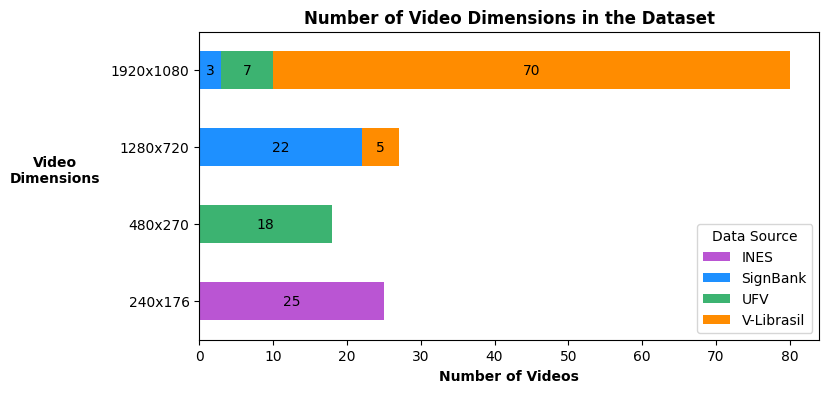

In [48]:
dimension_counts = video_metadata.sort_values('width').groupby('dimension_str').data_source.value_counts().unstack()
# rearrange rows, so the order goes from indexes 1,2,3,4 to 3,4,1,2
dimension_counts = dimension_counts.reindex(index=['240x176', '480x270', '1280x720', '1920x1080'])
# dimension_counts = dimension_counts[['240x176', '480x270', '1280x720', '1920x1080']]
ax = dimension_counts.plot(kind='barh', stacked=True, color=color_list_rgb, figsize=(8, 4))

# Add value labels on each bar segment
x_offset = np.zeros(len(dimension_counts.index))
for i, col in enumerate(dimension_counts.columns):
    values = dimension_counts[col]
    for j, v in enumerate(values):
        if not np.isnan(v):  # Only add label if value is not NaN
            ax.text(x_offset[j] + v/2, j, int(v),
                   ha='center', va='center', color='black')
        if not np.isnan(v):
            x_offset[j] += v

# add a legend
plt.legend(title='Data Source', labels=data_source_list)

# add a title
plt.title('Number of Video Dimensions in the Dataset', fontweight='bold')

# add a y label
# plt.ylabel('         Video\nDimensions', rotation=0, labelpad=40, fontweight='bold')
plt.ylabel('Video\nDimensions', rotation=0, labelpad=40, fontweight='bold')
plt.xlabel('Number of Videos', fontweight='bold')

# clearer yticks
plt.yticks(rotation=0)
# save
plt.savefig(final_save_dir + f"video_dimensions_bar_chart.png", dpi=1000, bbox_inches='tight')

In [27]:
word = 'animal'
word_metadata = video_metadata[video_metadata['label'] == word].reset_index(drop=True)
video_paths = [os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn) for fn in word_metadata['filename'][:4]]
video_frames = [get_frame(10, video_path) for video_path in video_paths]

True

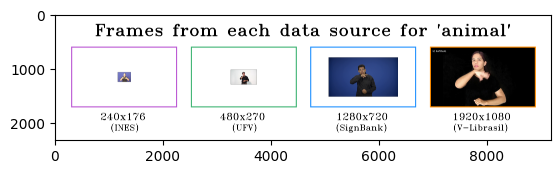

In [49]:
target_width = 1920
target_height = 1080
black_border = 2
color_border = 20
dimension_frames = []
for i, row in word_metadata[:4].iterrows():
    fn = row['filename']
    video_path = os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn)
    video_frame = get_frame(row['frame_count']//2-3, video_path)
    color = color_list_rgb_int[i]
    height, width = video_frame.shape[:2]
    if target_width > width:
        video_frame = cv2.copyMakeBorder(video_frame, top=black_border, bottom=black_border, left=black_border, right=black_border, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
        width_padding = (target_width - width) // 2 - black_border
        height_padding = (target_height - height) // 2 - black_border
        video_frame = cv2.copyMakeBorder(video_frame, top=height_padding, bottom=height_padding, left=width_padding, right=width_padding, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    video_frame = cv2.copyMakeBorder(video_frame, top=color_border, bottom=color_border, left=color_border, right=color_border, borderType=cv2.BORDER_CONSTANT, value=color)
    
    dimension_frames.append(video_frame)

font_size = 6
font_thickness = 5
font = cv2.FONT_HERSHEY_TRIPLEX

padded_annotated_frames = []
for i, frame in enumerate(dimension_frames):
    data_source = data_source_list[i]
    anno = f'{word_metadata.loc[i, "width"]}x{word_metadata.loc[i, "height"]}'
    bordered_frame = cv2.copyMakeBorder(frame, 0, 600, 0, 0, cv2.BORDER_CONSTANT, value=(255,255,255))

    textsize = cv2.getTextSize(anno, font, font_size, font_thickness)[0]
    text_x = (target_width - textsize[0]) // 2
    annotated_frame = cv2.putText(bordered_frame, anno, (text_x, 1350), font, font_size, (0, 0, 0), font_thickness)

    textsize = cv2.getTextSize(data_source, font, font_size, font_thickness)[0]
    text_x = (target_width - textsize[0]) // 2
    annotated_frame = cv2.putText(annotated_frame, f"({data_source})", (text_x, 1350 + int(textsize[1]*1.5)), font, 5, (0, 0, 0), font_thickness)
    
    padded_annotated_frames.append(annotated_frame)

gap = np.full((target_height + 390 + 250, 250, 3), 255, dtype=np.uint8)

final_frames = [padded_annotated_frames[0], gap, padded_annotated_frames[2], gap, padded_annotated_frames[1], gap, padded_annotated_frames[3]]
new_frame = np.concatenate(final_frames, axis=1)
new_frame = cv2.copyMakeBorder(new_frame, 600, 0, 300, 300, cv2.BORDER_CONSTANT, value=(255, 255, 255))
font_size = 10
font_thickness = 15
title = f"Frames from each data source for '{word}'"
textsize = cv2.getTextSize(title, font, font_size, font_thickness)[0]
text_x = (new_frame.shape[1] - textsize[0]) // 2
new_frame = cv2.putText(new_frame, title, (text_x, 400), font, font_size, (0, 0, 0), font_thickness)

plt.imshow(new_frame)
cv2.imwrite(final_save_dir + f"video_dimensions_for_{word}.png", cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))

#### FPS

In [37]:
video_metadata['round_fps'] = video_metadata['fps'].round(0).astype(int)
video_metadata.groupby('round_fps').data_source.value_counts()

round_fps  data_source
12         ne             25
24         vl              1
30         vl             47
           sb             25
           uf             25
60         vl             27
Name: count, dtype: int64

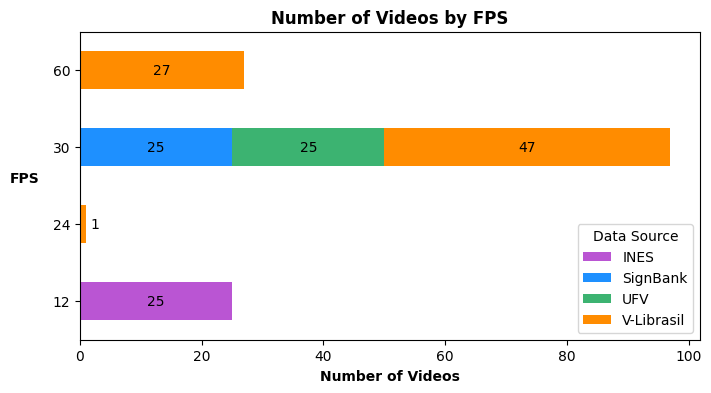

In [38]:
fps_counts = video_metadata.sort_values('round_fps').groupby('round_fps').data_source.value_counts().unstack()
ax = fps_counts.plot(kind='barh', stacked=True, color=color_list_rgb, figsize=(8, 4))

# Add value labels on each bar segment
x_offset = np.zeros(len(fps_counts.index))
for i, col in enumerate(fps_counts.columns):
    values = fps_counts[col]
    for j, v in enumerate(values):
        if not np.isnan(v):  # Only add label if value is not NaN
            if v == 1:
                ax.text(x_offset[j] + 2.5, j, int(v),
                       ha='center', va='center', color='black')
            else:
                ax.text(x_offset[j] + v/2, j, int(v),
                       ha='center', va='center', color='black')
        if not np.isnan(v):
            x_offset[j] += v

# add a legend
plt.legend(title='Data Source', labels=data_source_list, loc='lower right')

# add a title
plt.title('Number of Videos by FPS', fontweight='bold')

# add a y label
plt.ylabel('FPS', fontweight='bold', rotation=0, labelpad=20)
plt.xlabel('Number of Videos', fontweight='bold')

# clearer yticks
# plt.yticks(rotation=0)
plt.savefig(final_save_dir + f"fps_bar_chart.png", dpi=1000, bbox_inches='tight')


### Durations

In [83]:
data_source_list

['INES', 'SignBank', 'UFV', 'V-Librasil', 'V-Librasil', 'V-Librasil']

/tmp/ipykernel_8118/2472444630.py:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=video_metadata, x='duration_sec', hue='data_source', palette=color_list_rgb)


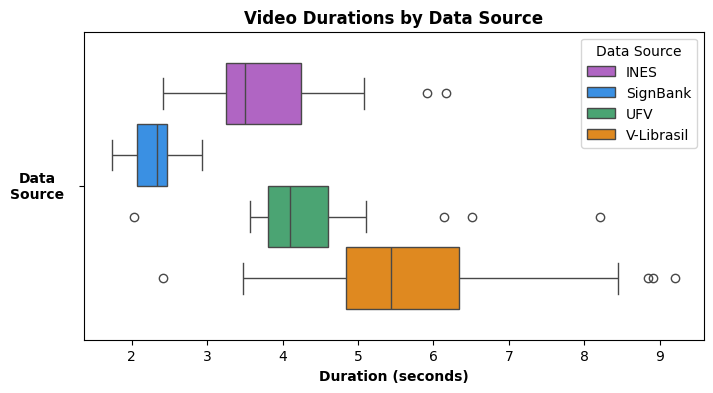

In [79]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=video_metadata, x='duration_sec', hue='data_source', palette=color_list_rgb)

# Add title and labels
plt.title('Video Durations by Data Source', fontweight='bold')
plt.xlabel('Duration (seconds)', fontweight='bold')
# legend
plt.legend(title='Data Source', labels=data_source_list[:4], loc='upper right')
ax = plt.gca()
ax.set_ylabel("Data\nSource", rotation=0, fontweight='bold')
ax.yaxis.set_label_coords(-.075, .45)  

plt.savefig(final_save_dir + f"video_durations_boxplot.png", dpi=1000, bbox_inches='tight')


# Preprocessing

### Pose - MediaPipe

### Motion Detection Measurement Methods

In [10]:
def get_motion_data(fn, fps):
    motion_dirA = path_to_root + f'data/interim/RawMotionMeasurements/versionA/'
    motion_dir = path_to_root + f'data/interim/RawMotionMeasurements/{motion_version}/'

    mm_basic = np.load(motion_dirA + fn.replace('.mp4','_basic.npy'))
    mm_bg_sub = np.load(motion_dirA + fn.replace('.mp4','_bg_sub.npy'))
    mm_lm = np.load(motion_dir + fn.replace('.mp4','_landmarks.npy'))
    mm_ma = np.load(motion_dir + fn.replace('.mp4','_motion_analysis.npy'), allow_pickle=True)

    mm_basic_norm = md.normalize_list_of_data(mm_basic)
    mm_bg_sub_norm = md.normalize_list_of_data(mm_bg_sub)
    mm_lm_norm = md.normalize_list_of_data(mm_lm)
    combined = md.weighted_average_motion([mm_basic_norm,mm_bg_sub_norm,mm_lm_norm])
    combined_norm = md.normalize_list_of_data(combined)

    window_duration = 0.334
    # Apply moving average
    mm_lm_ma = md.moving_average(mm_lm, fps, window_duration, verbose=True)
    combined_ma = md.moving_average(combined, fps, window_duration, verbose=True)

    # Normalize data
    mm_lm_ma_norm = md.normalize_list_of_data(mm_lm_ma)
    combined_ma_norm = md.normalize_list_of_data(combined_ma)

    return mm_basic_norm, mm_bg_sub_norm, mm_lm_norm, combined_norm, combined_ma, combined_ma_norm, mm_lm_ma, mm_lm_ma_norm

In [11]:
(metadata['original_duration_sec']-metadata['processed_duration_sec']).sort_values(ascending=False)[:10]

12     3.333333
71     3.236567
6      2.583333
42     2.000000
80     1.968633
86     1.968633
23     1.950000
32     1.835167
116    1.835167
28     1.801800
dtype: float64

In [34]:
i=12

In [35]:
single = metadata.iloc[i]
fn = single.filename_accented
word = single.label
fps = single.original_fps
video_dir = path_to_root + f'data/interim/RawCleanVideos/'
video_path = video_dir + fn
print(fn, single.data_source)

aniversário_ne_1.mp4 ne


In [36]:
mm_basic_norm, mm_bg_sub_norm, mm_lm_norm, combined_norm, combined_ma, combined_ma_norm, mm_lm_ma, mm_lm_ma_norm = get_motion_data(fn,fps)

window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size


In [55]:
md.play_video_with_motion_graph(
    video_path,
    [mm_basic_norm, mm_bg_sub_norm, mm_lm_norm, combined_norm],
    target_width=2666,
    target_height=2000,
    figsize = (8,3),
    dpi = 450,
    legend_labels = ['Basic', 'Background Subtraction', 'Landmarks Motion', 'Weighted Average of 3 Methods'],
    alpha = 0.75,
    colors = ['dodgerblue','green','mediumorchid','darkorange'],
    output_video_path = interim_save_dir + f'motion_for_{word}_all.mp4'
)

Saving video to: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_all.mp4


Progress: 81.1%
Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


In [56]:
md.play_video_with_motion_graph(
    video_path,
    [mm_basic_norm, mm_bg_sub_norm, mm_lm_norm, combined_ma_norm],
    target_width=2666,
    target_height=2000,
    figsize = (8,3),
    dpi = 450,
    legend_labels = ['Basic', 'Background Subtraction', 'Landmarks Motion', 'Moving Avg of Weighted Avg of 3 Methods'],
    alpha = 0.75,
    colors = ['dodgerblue','green','mediumorchid','darkorange'],
    output_video_path = interim_save_dir + f'motion_for_{word}_all_ma.mp4'
)

Saving video to: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_all_ma.mp4
Progress: 81.1%
Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


In [57]:
md.play_video_with_motion_graph(
    video_path,
    [combined_norm, combined_ma],
    # target_width=2000,
    # target_height=1500,
    # figsize = (10,3),
    # dpi = 300,
    target_width=2666,
    target_height=2000,
    figsize = (8,3),
    dpi = 450,
    legend_labels = ['Weighted Average of 3 Methods', 'Moving Average'],
    alpha=0.75,
    colors = ['orangered', 'firebrick'],
    output_video_path = interim_save_dir + f'motion_for_{word}_comb.mp4'
)

Saving video to: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_comb.mp4
Progress: 81.1%
Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


In [58]:
md.play_video_with_motion_graph(
    video_path,
    [mm_lm_norm, mm_lm_ma_norm],
    target_width=2666,
    target_height=2000,
    figsize = (8,3),
    dpi = 450,
    legend_labels = ['Landmarks Motion', 'Moving Average'],
    alpha = 0.75,
    colors = ['dodgerblue', 'rebeccapurple'],
    output_video_path = interim_save_dir + f'motion_for_{word}_lm.mp4'
)

Saving video to: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_lm.mp4
Progress: 81.1%
Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


In [49]:
combine_function = partial(horizontal_concat)

In [50]:
video_names = [f'motion_for_{word}_all.mp4', f'motion_for_{word}_comb.mp4', f'motion_for_{word}_lm.mp4']
video_paths = [interim_save_dir + video_name for video_name in video_names]
video_paths

['/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_all.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_comb.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_lm.mp4']

In [59]:
apply_to_videos(combine_function=combine_function, video_paths=video_paths, save_path=interim_save_dir+f"motions_for_{word}.mp4", max_dimension = 3000)


Video 1: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_all.mp4
  - FPS: 12.00
  - Frames: 74
  - Size: 2666x2000
  - Duration: 6.17s
Video 2: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_comb.mp4
  - FPS: 12.00
  - Frames: 74
  - Size: 2666x2000
  - Duration: 6.17s
Video 3: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_lm.mp4
  - FPS: 12.00
  - Frames: 74
  - Size: 2666x2000
  - Duration: 6.17s
Using highest FPS (12.00) from input videos as output FPS

Processing frames 0 to 74 at 12.0 FPS
Output duration: 6.17s
Scaling output from 7998x2000 to 3000x750
Trying alternative codec: mp4v
Output video size: 3000x750


[ERROR:0@1155.094] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@1155.094] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


Progress: 40.5% (30 frames processed)
Progress: 81.1% (60 frames processed)

Video saved successfully: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motions_for_aniversario.mp4
Total frames processed: 74
Final duration: 6.17s
File size: 2.1 MB


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motions_for_aniversario.mp4'

In [64]:
apply_to_videos(combine_function=combine_function, video_paths=[video_paths[0],video_paths[2]], save_path=interim_save_dir+f"motions_for_{word}_2.mp4", max_dimension = 3000)


Video 1: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_all.mp4
  - FPS: 12.00
  - Frames: 74
  - Size: 2666x2000
  - Duration: 6.17s
Video 2: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motion_for_aniversario_lm.mp4
  - FPS: 12.00
  - Frames: 74
  - Size: 2666x2000
  - Duration: 6.17s
Using highest FPS (12.00) from input videos as output FPS

Processing frames 0 to 74 at 12.0 FPS
Output duration: 6.17s
Scaling output from 5332x2000 to 2999x1125
Trying alternative codec: mp4v
Output video size: 2999x1125


[ERROR:0@1256.856] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@1256.856] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


Progress: 40.5% (30 frames processed)
Progress: 81.1% (60 frames processed)

Video saved successfully: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motions_for_aniversario_2.mp4
Total frames processed: 74
Final duration: 6.17s
File size: 2.5 MB


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/docs/assets/interim/motions_for_aniversario_2.mp4'

### Motion Start & End Frame Methods

### Scaling & Alignment

### Interpolation

### Summary

In [13]:
word = 'casa'

In [14]:
word_metadata = metadata[metadata['label'] == word]
word_metadata

,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
60,casa_ne_1.mp4,casa_ne_1.mp4,casa,casa,False,ne,12.00000,37,3.083333,4,32,29,2.416667,v4,0.146382,0.333248,0.293531,20,20
61,casa_sb_2.mp4,casa_sb_2.mp4,casa,casa,False,sb,29.97003,64,2.135467,1,59,59,1.968633,v4,0.083390,0.200587,0.214112,0,4
62,casa_uf_3.mp4,casa_uf_3.mp4,casa,casa,False,uf,29.97003,135,4.504500,12,106,95,3.169833,v4,0.072411,0.165205,0.178935,9,7
63,casa_vl_4.mp4,casa_vl_4.mp4,casa,casa,False,vl,29.97003,196,6.539867,21,175,155,5.171833,v4,0.106300,0.232975,0.248012,0,0
64,casa_vl_5.mp4,casa_vl_5.mp4,casa,casa,False,vl,29.97003,195,6.506500,8,164,157,5.238567,v4,0.126919,0.260175,0.272127,24,11
65,casa_vl_6.mp4,casa_vl_6.mp4,casa,casa,False,vl,59.94006,276,4.604600,0,259,260,4.337667,v4,0.134202,0.301444,0.337500,25,36


In [30]:
pose_video_paths = []
black_pose_video_paths = []
preprocessed_pose_video_paths = []

for i, row in word_metadata.iterrows():
    fn = row['filename']
    video_path = path_to_root + "/data/interim/RawCleanVideos/" + fn
    landmarks_path = path_to_root + f"/data/interim/RawPoseLandmarks/{pose_version}/" + fn.replace(".mp4", ".npy")
    lm_info = np.load(landmarks_path, allow_pickle=True)
    pose_video_path = path_to_root + "docs/assets/interim/" + f"pose_{fn}"
    pose_video_paths.append(pose_video_path)
    # draw_landmarks_on_video(video_path, lm_info, pose_video_path)

    fps = row['original_fps']
    black_pose_video_path = path_to_root + "docs/assets/interim/" + f"black_pose_{fn}"
    black_pose_video_paths.append(black_pose_video_path)
    # draw_landmarks_on_video_with_frame(lm_info, black_pose_video_path, base_frame=None, fps=fps)

    preprocessed_landmarks_path = path_to_root + f"/data/preprocessed/landmarks/{preprocess_version}/" + fn.replace(".mp4", ".npy")
    preprocessed_lm_info = np.load(preprocessed_landmarks_path, allow_pickle=True)
    preprocessed_pose_video_path = path_to_root + "docs/assets/interim/" + f"preprocessed_{fn}"
    preprocessed_pose_video_paths.append(preprocessed_pose_video_path)
    # draw_landmarks_on_video_with_frame(preprocessed_lm_info, preprocessed_pose_video_path, base_frame=None, fps=fps)

    print(len(lm_info), len(preprocessed_lm_info))

37 29
64 59
135 95
196 155
195 157
276 260


In [29]:
len(preprocessed_lm_info),len(lm_info)

(260, 276)

In [23]:
combine_function = partial(four_signs_for_word, word=word)

In [ ]:
apply_to_videos(combine_function=combine_function, video_paths=pose_video_paths, save_path=interim_save_dir+f"pose_videos_for_{word}.mp4")

In [25]:
combine_function = partial(four_signs_for_word_two_rows, word=word)

In [ ]:
apply_to_videos(combine_function=combine_function, video_paths=pose_video_paths[:4]+black_pose_video_paths[:4], save_path=interim_save_dir+f"double_pose_videos_for_{word}.mp4")

In [16]:
combine_function = partial(four_signs_for_word_two_rows, word=word)

In [31]:
apply_to_videos(combine_function=combine_function, video_paths=pose_video_paths[:4]+preprocessed_pose_video_paths[:4], save_path=interim_save_dir+f"preprocessed_videos_for_{word}.mp4")

Video 1: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/pose_casa_ne_1.mp4
  - FPS: 12.00
  - Frames: 32
  - Size: 240x176
  - Duration: 2.67s
Video 2: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/pose_casa_sb_2.mp4
  - FPS: 29.97
  - Frames: 59
  - Size: 1280x720
  - Duration: 1.97s
Video 3: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/pose_casa_uf_3.mp4
  - FPS: 29.97
  - Frames: 135
  - Size: 1920x1080
  - Duration: 4.50s
Video 4: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/pose_casa_vl_4.mp4
  - FPS: 29.97
  - Frames: 178
  - Size: 1920x1080
  - Duration: 5.94s
Video 5: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/preprocessed_casa_ne_1.mp4
  - FPS: 12.00
  - Frames: 29
  - Size: 640x480
  - Duration: 2.42s
Video 6: c:/Users//benthompson//source//prepos//brsl/docs/assets/interim/preprocessed_casa_sb_2.mp4
  - FPS: 29.97
  - Frames: 59
  - Size: 640x480
  - Duration: 1.97s
Video 7: c:/Users

'c:\\Users\\benthompson\\source\\prepos\\brsl\\docs\\assets\\interim\\preprocessed_videos_for_casa.mp4'

In [ ]:
# video_to_gif(video_path="comb_video.mp4", output_path="comb_video.gif", loop=0, quality=100, fps=15, final_frame_duration= 500)

GIF created successfully: comb_video.gif
  - Frames: 164
  - Duration: 11.26 seconds
  - Size: 1920x292
  - File size: 8803.2 KB


'comb_video.gif'

# Modelling

### Train / Test Split

### Frame Sampling

### Cross Validation Split (StratifiedGroupKFold)

### Data Augmentation